# Welcome to the Assisted Early Diagnosis of Persistent Pulmonary Hypertension (PPHN) Model

# Introduction

*Here you can download the necessary libraries need to run this model.*

This model was created in order to assist physicians in early diagnosis and treatment of Persistent Pulmonary Hypertensions in late preterm and term infants.

Given the target population of this model, it is expected to be used either in NICU settings or those undergoing routine monitoring following diagnosis of PPHN.

*This model offers*
- APGAR scoring tool
- PPHN Severity calculator
- PPHN Risk Calculator

*as well as other valuable tools*

This model utilizes the data provided in the  observational study conducted at The Children’s Hospital & the Institute of Child Health, Multan, Pakistan, from July 2011 to June 2012.

https://pmc.ncbi.nlm.nih.gov/articles/PMC3858931/

In [ ]:
#Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [ ]:
pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.0 MB/s eta 0:00:00


In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


# ICD Code Checker and APGAR Score Calculator

To start, the model implements an ICD Code Checker to ensure that this tool is being utilized for appropriate patients.

Then it implements an APGAR Score Calculator. The APGAR score is an evaluation method to evaluate an infant's transition to extrauterine life. The five factors observed are color, heart rate, grimace,

**ICD CODE CHECKER**

In [ ]:
# ICD Code Checker

# Valid ICD-10 codes for PPHN or related neonatal respiratory conditions
VALID_ICD_CODES = {
    "P29.3": "Persistent pulmonary hypertension of the newborn",
    "P28.5": "Respiratory failure of newborn",
    "P22.0": "Respiratory distress syndrome of newborn",
    "P28.4": "Other apnea of newborn",
    "P24.0": "Meconium aspiration syndrome",
    "P36.0": "Sepsis of newborn",
    # Add more if needed
}

def check_icd_code():
    RED = "\033[91m"
    END = "\033[0m"

    print(RED + "WARNING: This tool is designed for use ONLY in neonates (newborns)." + END)
    print("Enter ICD-10 code(s) related to the infant (separate by commas if multiple):")
    icd_input = input("ICD-10 code(s): ")
    codes = [code.strip().upper() for code in icd_input.split(",")]

    matched = {code: VALID_ICD_CODES[code] for code in codes if code in VALID_ICD_CODES}

    if not matched:
        print("\n No matching ICD-10 codes found for PPHN or related neonatal conditions.")
        print("Model use is not recommended. Please verify the diagnosis.")
        return False
    else:
        print("\n Valid ICD-10 code(s) detected:")
        for code, desc in matched.items():
            print(f"  {code}: {desc}")
        return True

print("\n Prior to continuing to use the model, ensure you have the following information:")
print("\n Gestational age (in weeks), gender, delivery mode, need for resuscitation, presence of fetal distress,")
print("\n incidence of birth asphyxia, maternal diabetes, maternal hypertension, Meconium-stained liquor, present lung disorders, and sepsis")
print("\n")

if check_icd_code():
    print("\n Proceed with entering patient details.")
else:
    print("\n Model use is not recommended. Please verify the diagnosis.")


 Prior to continuing to use the model, ensure you have the following information:

 Gestational age (in weeks), gender, delivery mode, need for resuscitation, presence of fetal distress,

 incidence of birth asphyxia, maternal diabetes, maternal hypertension, Meconium-stained liquor, present lung disorders, and sepsis


Enter ICD-10 code(s) related to the infant (separate by commas if multiple):
ICD-10 code(s): P29.3

 Valid ICD-10 code(s) detected:
  P29.3: Persistent pulmonary hypertension of the newborn

 Proceed with entering patient details.


**APGAR SCORE CALCULATOR**

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Apgar scoring options
scoring = {
    "Appearance": [("Blue or pale all over", 0), ("Blue at extremities, body pink", 1), ("Completely pink", 2)],
    "Pulse": [("Absent", 0), ("Less than 100 bpm", 1), ("Over 100 bpm", 2)],
    "Grimace Response": [("No response", 0), ("Grimace or weak cry", 1), ("Crying, pulling away, or coughing", 2)],
    "Activity": [("Limp, no movement", 0), ("Some flexion of arms and legs", 1), ("Active motion", 2)],
    "Respiration": [("Absent", 0), ("Slow or irregular", 1), ("Good, crying", 2)],
}

# Create dropdowns with a default "--" option
dropdowns = {}
for name, options in scoring.items():
    dropdowns[name] = widgets.Dropdown(
        options=[("--", None)] + [(desc, score) for desc, score in options],
        description=name + ":",
    )

submit_button = widgets.Button(description="Calculate APGAR Score", button_style="success")
output = widgets.Output()

# Callback function
def on_submit(button):
    with output:
        output.clear_output()

        # Check if all selections are made
        if any(widget.value is None for widget in dropdowns.values()):
            display(HTML("<h4 style='color:red'> Please complete all fields before calculating the score.</h4>"))
            return

        # Calculate total Apgar score
        total_score = sum(widget.value for widget in dropdowns.values())

        # Display result
        display(HTML(f"<h3 style='color:green'>Total APGAR Score: {total_score}/10</h3>"))

        # Action items and monitoring plans
        if total_score <= 3:
            display(HTML("<h4 style='color:red'> Critical: Immediate resuscitation required.</h4>"))
            display(HTML("""
                <ul>
                    <li>Initiate full resuscitation protocol (NRP)</li>
                    <li>Prepare for NICU admission</li>
                    <li>Continuous cardiorespiratory monitoring</li>
                    <li><strong>Monitoring Frequency:</strong> Every 5 minutes for first 30 minutes</li>
                    <li><strong>Follow-up:</strong> Reassess APGAR at 5, 10, and 20 minutes; neonatal consult within 1 hour</li>
                </ul>
            """))
        elif total_score <= 6:
            display(HTML("<h4 style='color:orange'> Caution: Close observation and possible intervention.</h4>"))
            display(HTML("""
                <ul>
                    <li>Provide respiratory or thermal support if needed</li>
                    <li>Monitor vitals closely</li>
                    <li><strong>Monitoring Frequency:</strong> Every 15 minutes for 1 hour</li>
                    <li><strong>Follow-up:</strong> Reassess APGAR at 10 minutes; re-evaluate at 1–2 hours</li>
                </ul>
            """))
        else:
            display(HTML("<h4 style='color:green'> Stable: Routine care and continued monitoring.</h4>"))
            display(HTML("""
                <ul>
                    <li>Continue routine postnatal care</li>
                    <li>Monitor for any changes</li>
                    <li><strong>Monitoring Frequency:</strong> Every 30–60 minutes as per routine nursery protocol</li>
                    <li><strong>Follow-up:</strong> Routine newborn check at 24 hours</li>
                </ul>
            """))

# Connect button to function
submit_button.on_click(on_submit)

# Display interface
display(HTML("<h2>APGAR Score Calculator</h2>"))
for widget in dropdowns.values():
    display(widget)
display(submit_button)
display(output)


Dropdown(description='Appearance:', options=(('--', None), ('Blue or pale all over', 0), ('Blue at extremities…

Dropdown(description='Pulse:', options=(('--', None), ('Absent', 0), ('Less than 100 bpm', 1), ('Over 100 bpm'…

Dropdown(description='Grimace Response:', options=(('--', None), ('No response', 0), ('Grimace or weak cry', 1…

Dropdown(description='Activity:', options=(('--', None), ('Limp, no movement', 0), ('Some flexion of arms and …

Dropdown(description='Respiration:', options=(('--', None), ('Absent', 0), ('Slow or irregular', 1), ('Good, c…

Button(button_style='success', description='Calculate APGAR Score', style=ButtonStyle())

Output()

# PPHN Severity Assessment Tool

Next, the model utilizes the provided data to determine the severity of the patient. This is determined by factors such as gestational age, gender, need for resuscitation, birth asphyxia, maternal diabetes, maternal hypertension, meconium-stained liquor, lung disorders, and sepsis.

The output provides a severity, mortality risk, and suggested treatment.

**PATIENT DATA INPUT FOR PPHN ASSESSMENT TOOL**

In [ ]:
# PATIENT DATA INPUT SECTION

def get_patient_details():
    print("\nPlease enter the following patient details:")
    gestational_age = input("Gestational age (in weeks): ")
    gender = input("Gender (Male/Female): ")
    mode_of_delivery = input("Delivery mode (SVD/C-section): ")
    resuscitation = input("Resuscitation needed (None/Oxygen/PPV): ")
    fetal_distress = input("Fetal distress (Yes/No): ")
    birth_asphyxia = input("Birth asphyxia (Yes/No): ")
    maternal_dm = input("Maternal diabetes (Yes/No): ")
    maternal_htn = input("Maternal hypertension (Yes/No): ")
    meconium = input("Meconium-stained fluid (Yes/No): ")
    lung_disorder = input("Lung disorder (None/MAS/RDS): ")
    sepsis = input("Sepsis (Yes/No): ")

    return {
        "gestational_age": int(gestational_age),
        "gender": gender.lower(),
        "mode_of_delivery": mode_of_delivery.lower(),
        "resuscitation": resuscitation.lower(),
        "fetal_distress": fetal_distress.lower() == "yes",
        "birth_asphyxia": birth_asphyxia.lower() == "yes",
        "maternal_dm": maternal_dm.lower() == "yes",
        "maternal_htn": maternal_htn.lower() == "yes",
        "meconium": meconium.lower() == "yes",
        "lung_disorder": lung_disorder.lower(),
        "sepsis": sepsis.lower() == "yes",
    }


# RISK SCORING

def estimate_risk(patient):
    score = 0

    # Gestational age
    if patient["gestational_age"] < 37:
        score += 2  # higher risk in preterms
    else:
        score += 1

    # Gender
    if patient["gender"] == "male":
        score += 1

    # Resuscitation needed
    if patient["resuscitation"] == "ppv":
        score += 2
    elif patient["resuscitation"] == "oxygen":
        score += 1

    # Complications
    if patient["birth_asphyxia"]:
        score += 2
    if patient["lung_disorder"] == "rds":
        score += 2
    elif patient["lung_disorder"] == "mas":
        score += 1
    if patient["sepsis"]:
        score += 2
    if patient["fetal_distress"]:
        score += 1

    return score


# SEVERITY INTERPRETATION

def interpret_results(score):
    if score <= 3:
        severity = "Mild"
        mortality_risk = "Low"
        treatment = "Oxygen therapy and monitoring"
    elif 4 <= score <= 6:
        severity = "Moderate"
        mortality_risk = "Medium"
        treatment = "CPAP or non-invasive support with close monitoring"
    else:
        severity = "Severe"
        mortality_risk = "High"
        treatment = "Intubation/IMV and consider advanced therapies (e.g., inhaled nitric oxide)"

    return severity, mortality_risk, treatment


# MAIN RUNNER

def run_pphn_assessment():
    print("=== PPHN NICU ASSESSMENT TOOL ===")

    patient = get_patient_details()
    score = estimate_risk(patient)
    severity, mortality_risk, treatment = interpret_results(score)

    print("\n--- PPHN Assessment Result ---")
    print(f" Estimated Severity Level: {severity}")
    print(f" Mortality Risk: {mortality_risk}")
    print(f" Suggested Treatment Plan: {treatment}")


# Run the tool
run_pphn_assessment()


=== PPHN NICU ASSESSMENT TOOL ===

Please enter the following patient details:
Gestational age (in weeks): 32
Gender (Male/Female): male
Delivery mode (SVD/C-section): c-section
Resuscitation needed (None/Oxygen/PPV): oxygen
Fetal distress (Yes/No): no
Birth asphyxia (Yes/No): yes
Maternal diabetes (Yes/No): no
Maternal hypertension (Yes/No): no
Meconium-stained fluid (Yes/No): no
Lung disorder (None/MAS/RDS): none
Sepsis (Yes/No): yes

--- PPHN Assessment Result ---
 Estimated Severity Level: Severe
 Mortality Risk: High
 Suggested Treatment Plan: Intubation/IMV and consider advanced therapies (e.g., inhaled nitric oxide)


# Mortality Risk Prediction and Graphic Representation
Next, the model will provide a numerical mortality risk. Both categorical and numerical representations of the patient's condition can be beneficial to improving the interpretability and transparency of the data provided by the tool.

Here, RR scores and associated risk factors are used to implement the physician to input the patient's values. Then, the model will calculate mortality as well as plot it against sample patients to provide a visual representation of the patient.

**MORTALITY RISK PREDICTION**

In [ ]:
# MORTALITY RISK PREDICTOR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML
import ipywidgets as widgets

# Risk factors and assigned RR scores
risk_factors = {
    "Gender": {"Male": 2, "Female": 0.43},
    "Mode of Delivery": {"SVD": 1, "C-section": 1},
    "Resuscitation": {"Not needed": 0.8, "Only oxygen": 1, "PPV": 1.5},
    "Fetal Distress": {"Yes": 1, "No": 0},
    "Birth Asphyxia": {"Yes": 2.5, "No": 0},
    "Lung Disorder": {"None": 0, "MAS": 5, "RDS": 5},
    "Sepsis": {"Yes": 2, "No": 0},
    "PPHN Severity": {"Mild": 1, "Moderate": 1.3, "Severe": 0.22},
    "Respiratory Support": {"Oxygen with mask": 0, "CPAP": 0, "IMV": 0.9},
}

# Expanded sample data points for RR and Mortality
# Each list of RR scores corresponds to different patient risk profiles.
sample_rr = [
    0.22, 0.43, 0.8, 1, 1.3, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7, 8  # Various combinations of risk factors
]
sample_mortality = [
    40, 43, 45, 47, 49, 50, 52, 55, 56, 58, 60, 62, 65, 70, 75  # Corresponding mortality rates
]

# Model Fit
X_sample = np.array(sample_rr).reshape(-1, 1)
y_sample = np.array(sample_mortality)
model = LinearRegression().fit(X_sample, y_sample)

# Physician input dropdown
dropdowns = {}
for name, options in risk_factors.items():
    all_options = ["-- Select --"] + list(options.keys())
    dropdowns[name] = widgets.Dropdown(options=all_options, description=name + ":")

submit_button = widgets.Button(description="Predict Mortality", button_style="danger")
output = widgets.Output()

# Callback function
def on_submit(button):
    with output:
        output.clear_output()

        # Compute total risk score
        total_rr = 0
        for name, widget in dropdowns.items():
            selection = widget.value
            if selection != "-- Select --":  # Ignore if not selected
                score = risk_factors[name][selection]
                total_rr += score

        # Predict mortality
        predicted_mortality = model.predict(np.array([[total_rr]]))[0]

        # Display prediction
        display(HTML(f"<h3 style='color:red'>Predicted Mortality Risk: {predicted_mortality:.1f}%</h3>"))

        # Plot graph
        plt.figure(figsize=(8, 5))
        plt.scatter(sample_rr, sample_mortality, label="Sample Patients", color="blue")
        plt.scatter(total_rr, predicted_mortality, color="red", s=100, label="Current Patient")
        plt.plot(X_sample, model.predict(X_sample), color="gray", linestyle="--", label="Linear Fit")
        plt.xlabel("Relative Risk Score")
        plt.ylabel("Mortality (%)")
        plt.title("Mortality Risk vs Relative Risk Score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Connect button to function
submit_button.on_click(on_submit)

# Display interface
display(HTML("<h2>NICU PPHN Mortality Risk Predictor</h2>"))
for widget in dropdowns.values():
    display(widget)
display(submit_button)
display(output)


Dropdown(description='Gender:', options=('-- Select --', 'Male', 'Female'), value='-- Select --')

Dropdown(description='Mode of Delivery:', options=('-- Select --', 'SVD', 'C-section'), value='-- Select --')

Dropdown(description='Resuscitation:', options=('-- Select --', 'Not needed', 'Only oxygen', 'PPV'), value='--…

Dropdown(description='Fetal Distress:', options=('-- Select --', 'Yes', 'No'), value='-- Select --')

Dropdown(description='Birth Asphyxia:', options=('-- Select --', 'Yes', 'No'), value='-- Select --')

Dropdown(description='Lung Disorder:', options=('-- Select --', 'None', 'MAS', 'RDS'), value='-- Select --')

Dropdown(description='Sepsis:', options=('-- Select --', 'Yes', 'No'), value='-- Select --')

Dropdown(description='PPHN Severity:', options=('-- Select --', 'Mild', 'Moderate', 'Severe'), value='-- Selec…

Dropdown(description='Respiratory Support:', options=('-- Select --', 'Oxygen with mask', 'CPAP', 'IMV'), valu…

Button(button_style='danger', description='Predict Mortality', style=ButtonStyle())

Output()

# PPHN Summary and Remote Symptom Monitoring Tool

This section implements the ability of the tool to increase education, transparency, and the ability for remote symptom monitoring.

Here, a description of the condition and common symptoms are provided. Additionally, there is a simple tool (where theoretically) vitals will be able to be entered and directions given on next steps.

Having key information provided during these vitals checks enables caretakers to stay informed on potential changes in condition.

In [ ]:
# Required libraries
!pip install ipywidgets --quiet
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Disease Summary

def show_disease_summary():
    summary_html = """
    <h2>Persistent Pulmonary Hypertension of the Newborn (PPHN)</h2>
    <p><strong>What is it?</strong><br>
    PPHN is a condition where a newborn’s circulation continues to bypass the lungs after birth, preventing proper oxygenation.</p>

    <p><strong>Why does it happen?</strong><br>
    It can be due to prematurity, lung issues (like MAS or RDS), or complications during delivery.</p>

    <p><strong>Symptoms Include:</strong>
    <ul>
        <li>Rapid breathing</li>
        <li>Low oxygen despite support</li>
        <li>Cyanosis (blue coloring)</li>
    </ul></p>

    <p><strong>How is it treated?</strong>
    <ul>
        <li>Oxygen therapy (CPAP, oxygen mask, or ventilator)</li>
        <li>Medications to relax blood vessels</li>
        <li>Sometimes nitric oxide or ECMO (in severe cases)</li>
    </ul></p>

    <p><strong>What to expect:</strong><br>
    Most babies recover with close monitoring. Severity guides recovery time and interventions. Frequent assessments help prevent complications.</p>
    """
    display(HTML(summary_html))



# Monitoring Frequency

def show_monitoring_frequency(severity):
    schedule = {
        "Mild": ("Vitals every 6 hours", "Follow-up echo in 3–5 days"),
        "Moderate": ("Vitals every 4 hours", "Daily labs + echo in 48 hours"),
        "Severe": ("Continuous monitoring (ICU)", "Daily consults: cardiology/pulmonology")
    }
    if severity in schedule:
        freq, followup = schedule[severity]
        display(HTML(f"""
            <h3> Monitoring Frequency for {severity} PPHN</h3>
            <p><strong>Vitals:</strong> {freq}</p>
            <p><strong>Follow-up:</strong> {followup}</p>
        """))


# Remote Monitoring

def check_remote_values(spo2, hr):
    alerts = []
    if spo2 < 92:
        alerts.append("<span style='color:red'> SpO₂ is low. Contact physician immediately.</span>")
    if hr < 100 or hr > 180:
        alerts.append("<span style='color:orange'> Heart rate is outside normal range. Monitor and recheck.</span>")
    if not alerts:
        alerts.append("<span style='color:green'> All values are within normal limits.</span>")
    display(HTML("<br>".join(alerts)))


# Age-based Trends

def show_age_based_trends(age_days):
    if age_days < 7:
        msg = "Close monitoring required; stabilization is typically ongoing."
    elif age_days < 30:
        msg = "Many infants begin showing respiratory improvement. Echo may reveal pressure improvements."
    else:
        msg = "Most stable cases show improvement or weaning off respiratory support."
    display(HTML(f"<h3> Age-Based Trend Prediction</h3><p>{msg}</p>"))


# ============================
severity_dropdown = widgets.Dropdown(
    options=["-- Select Severity --", "Mild", "Moderate", "Severe"],
    value="-- Select Severity --",
    description="Severity:",
    style={'description_width': 'initial'}
)

spo2_slider = widgets.IntSlider(
    value=95,
    min=70,
    max=100,
    step=1,
    description='SpO₂:',
    style={'description_width': 'initial'}
)

hr_slider = widgets.IntSlider(
    value=130,
    min=60,
    max=220,
    step=1,
    description='Heart Rate:',
    style={'description_width': 'initial'}
)

age_slider = widgets.IntSlider(
    value=5,
    min=0,
    max=90,
    step=1,
    description='Age (days):',
    style={'description_width': 'initial'}
)

submit_button = widgets.Button(
    description='Submit Info',
    button_style='primary'
)

output_box = widgets.Output()


def on_submit_clicked(b):
    with output_box:
        clear_output()
        # Ensure a valid severity is chosen
        if severity_dropdown.value == "-- Select Severity --":
            display(HTML("<span style='color:red'><strong>Please select a valid PPHN severity.</strong></span>"))
            return

        show_monitoring_frequency(severity_dropdown.value)
        check_remote_values(spo2_slider.value, hr_slider.value)
        show_age_based_trends(age_slider.value)
        show_disease_summary()


submit_button.on_click(on_submit_clicked)

# Layout for interaction
display(HTML("<h2 style='color:#1a73e8'> PPHN Monitoring Assistant</h2>"))
display(severity_dropdown, spo2_slider, hr_slider, age_slider, submit_button, output_box)


Dropdown(description='Severity:', options=('-- Select Severity --', 'Mild', 'Moderate', 'Severe'), style=Descr…

IntSlider(value=95, description='SpO₂:', min=70, style=SliderStyle(description_width='initial'))

IntSlider(value=130, description='Heart Rate:', max=220, min=60, style=SliderStyle(description_width='initial'…

IntSlider(value=5, description='Age (days):', max=90, style=SliderStyle(description_width='initial'))

Button(button_style='primary', description='Submit Info', style=ButtonStyle())

Output()

# Model Performance Metrics
This section is meant to show how often the model would be accurate in classifying the mortality rate of a patient. Currently, this is testing synthesized data. However, if the user has real, labelled data it can then be used to train the model further.

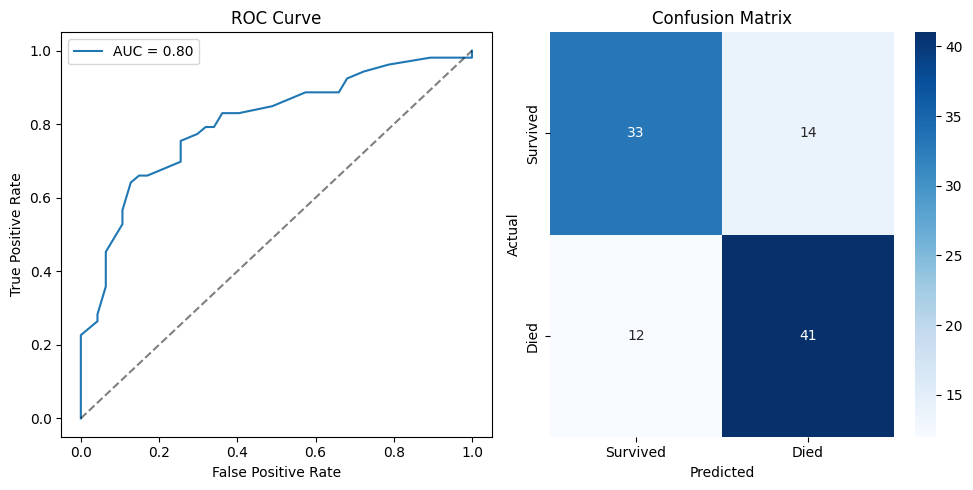

{'Accuracy': 0.74,
 'Precision': 0.7454545454545455,
 'Recall': 0.7735849056603774,
 'F1 Score': 0.7592592592592593,
 'ROC AUC': np.float64(0.8036932958651144)}

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated Patient Dataset (given lack of labeled data)
np.random.seed(42)

n_samples = 100
simulated_data = pd.DataFrame({
    "birth_asphyxia": np.random.choice([1, 0.4], n_samples),
    "sepsis": np.random.binomial(1, 0.3, n_samples),
    "RDS": np.random.binomial(1, 0.2, n_samples),
    "PPV": np.random.binomial(1, 0.35, n_samples),
    "severe_PPHN": np.random.binomial(1, 0.45, n_samples),
    "IMV": np.random.binomial(1, 0.5, n_samples),
})

# Weighted scores
weights = {
    "birth_asphyxia": 2.5,
    "sepsis": 2,
    "RDS": 5,
    "PPV": 1.5,
    "severe_PPHN": 0.22,
    "IMV": 0.9,
}

# Calculate total risk score
simulated_data["risk_score"] = simulated_data[list(weights)].dot(pd.Series(weights))

# Probability using sigmoid
simulated_data["predicted_mortality_prob"] = 1 / (1 + np.exp(-0.2 * (simulated_data["risk_score"] - 4.5)))

# Simulate mortality outcome
simulated_data["mortality"] = np.random.binomial(1, simulated_data["predicted_mortality_prob"])

# Train logistic regression model
X = simulated_data [list(weights)]
y = simulated_data["mortality"]
model = LogisticRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)
y_proba = model.predict_proba(X)[:, 1]

# Evaluation Metrics
metrics = {
    "Accuracy": accuracy_score(y, y_pred),
    "Precision": precision_score(y, y_pred),
    "Recall": recall_score(y, y_pred),
    "F1 Score": f1_score(y, y_pred),
    "ROC AUC": roc_auc_score(y, y_proba)
}

# Confusion Matrix?
conf_matrix = confusion_matrix(y, y_pred)

# Plot ROC Curve
plt.figure(figsize=(10, 5))

# ROC curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {metrics['ROC AUC']:.2f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Survived", "Died"], yticklabels=["Survived", "Died"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

metrics
